# Transfer Learning with Tensorflow pt1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [1]:
# Get data (10% of food classes from Food101)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-06-13 15:44:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.185.112, 216.58.212.176, 142.250.74.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.185.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  304K 9m1s
    50K .......... .......... .......... .......... ..........  0%  590K 6m50s
   100K .......... .......... .......... .......... ..........  0% 1,52M 5m8s
   150K .......... .......... .......... .......... ..........  0% 1,47M 4m19s
   200K .......... .......... .......... .......... ..........  0%  506K 4m32s
   250K .......... .......... .......... .......... ..........  0% 8,76M 3m49s
   300K .......... .......... .......... .......... ..........  0%  6

In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to loamd in our images in batches.

In [1]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training and test directory
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory( train_dir,
                                                target_size=IMAGE_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the mosst popular callback:

* Tracking experiment with the TensorBoard callback
* Model checkpoint with The ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [2]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating Models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub

We can access pretrained models on: https://tfhub.dev

In [3]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [4]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [5]:
# Let's make a create_model function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
        should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the already learned patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,)) # specify input shape

    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating and testing ResNet TensorFlow Hub feature Extraction model

In [6]:
# Create ResNet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [8]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [9]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                    epochs=5,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                            experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230613-162316
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8711 - accuracy: 0.3733 - val_loss: 1.1689 - val_accuracy: 0.6284
Epoch 2/5
24/24 [==============================] - 10s 446ms/step - loss: 0.8983 - accuracy: 0.7333 - val_loss: 0.8470 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 10s 421ms/step - loss: 0.6161 - accuracy: 0.8307 - val_loss: 0.7350 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 10s 433ms/step - loss: 0.4745 - accuracy: 0.8827 - val_loss: 0.7050 - val_accuracy: 0.7732
Epoch 5/5
24/24 [==============================] - 10s 423ms/step - loss: 0.3841 - accuracy: 0.9133 - val_loss: 0.6720 - val_accuracy: 0.7812


Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples

In [10]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

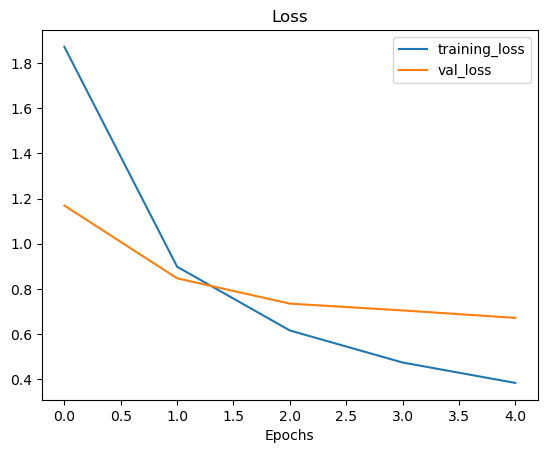

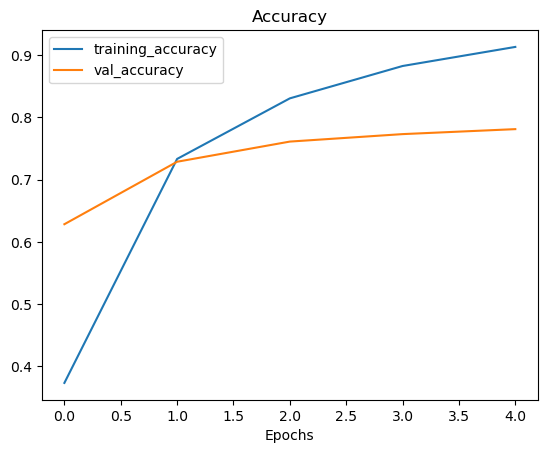

In [11]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNETB0 TensorFlow Hub Feature Extraction model

In [12]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)

In [13]:
# Compile EfficientNet model
efficientnet_model.compile( loss="categorical_crossentropy",
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

In [15]:
# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit( train_data,
                                                epochs=5,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[create_tensorboard_callback( dir_name="tensorflow_hub",
                                                                                        experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230613-163833
Epoch 1/5
24/24 [==============================] - 16s 441ms/step - loss: 1.8742 - accuracy: 0.4333 - val_loss: 1.3106 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 9s 396ms/step - loss: 1.0718 - accuracy: 0.7787 - val_loss: 0.8667 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 9s 397ms/step - loss: 0.7651 - accuracy: 0.8267 - val_loss: 0.6996 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 9s 394ms/step - loss: 0.6167 - accuracy: 0.8640 - val_loss: 0.6107 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 9s 397ms/step - loss: 0.5195 - accuracy: 0.8933 - val_loss: 0.5609 - val_accuracy: 0.8600


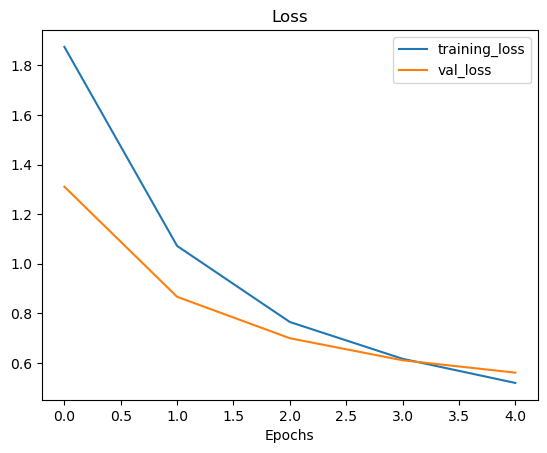

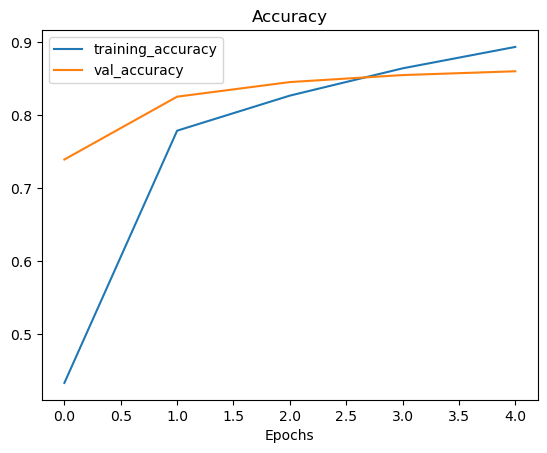

In [17]:
# Plot training curves
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever
* **"Feature extraction" transfer** learning - use the prelearned patterns of an existing model
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers


### Comparing our models results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of training images" \
    --one_shot 

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/qRONTgZGQeqjI5zDowXOtQ/#scalars&run=efficientnetb0%5C20230613-163833

In [25]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/qRONTgZGQeqjI5zDowXOtQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of training images
	Id                   qRONTgZGQeqjI5zDowXOtQ
	Created              2023-06-13 17:02:47 (5 minutes ago)
	Updated              2023-06-13 17:03:14 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5919058


Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE